# SpeedyWeather. Installation and use

_Dr. Anna Denvil-Sommer (NCAS, University of Reading)_

🌍_SpeedyWeather.jl_ is a global atmospheric model with simplified representations of processes like clouds, radiation, and precipitation. It’s designed as a flexible, modular library, making it easy to run fast simulations, experiment with model components, and interactively explore the building blocks of climate models.

Unlike full Earth System Models, SpeedyWeather is lightweight and focused on the atmosphere, making it ideal for learning, testing ideas, and understanding how model choices affect climate simulations.

More details: https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/ 

🎉 _By the end of this notebook, you will be able to build and run your own SpeedyWeather.jl configuration and analyze its various components._ 

## 📦 Prerequisites 

- Please follow these instructions to install the required software:

1. If you want to run SpeedyWeather in a Jupyter Notebook, open a terminal in the Jupyter web interface. Otherwise open a regular terminal.
2. Install Julia:
  ```
  curl -fsSL https://install.julialang.org | sh
  ```
  (If you need further information about installing Julia click here: [https://julialang.org/install/](https://julialang.org/install/).)
  
3. Start the Julia terminal by typing:
  ```
  julia
  ```

  In the Julia terminal type:
  ```
  using Pkg
  ```

  to use the package manager.

4. If you want to run SpeedyWeather in a Jupyter Notebook, install the IJulia package in the Julia terminal:
  ```
  Pkg.add("IJulia")
  ```


A Julia kernel should now be available when opening a new notebook.

5. Install SpeedyWeather, GeoMakie & CairoMakie in the Julia terminal:
  ```
  Pkg.add("SpeedyWeather")
  Pkg.add("GeoMakie")
  Pkg.add("CairoMakie")
  Pkg.add("NCDatasets")
  ```

 
  > *Note: There is no requirement to know the Julia language; however, installing it is necessary in order to run SpeedyWeather.*

- To simplify data analysis, we recommend installing **ncvis**: [https://github.com/SEATStandards/ncvis](https://github.com/SEATStandards/ncvis).  
  > *This modern alternative to ncview allows you to quickly inspect the NetCDF datasets you will generate.*

# How to run SpeedyWeather

GeoMakie.jl is a Julia package for plotting geospatial data on a given map projection. It is built on top of the Makie.jl plotting ecosystem.

CairoMakie uses Cairo.jl to draw vector graphics to SVG and PDF. You should use it if you want to achieve the highest-quality plots for publications.

Run this to check your setup:

In [1]:
using SpeedyWeather
using GeoMakie, CairoMakie

### 🌐 1. Defining the Simulation Domain: Spectral Grid and Vertical Levels 

🚨 Every simulation in SpeedyWeather.jl starts by setting up a _SpectralGrid_, which defines the model’s horizontal resolution (on a sphere) and the number of vertical levels.

Unlike traditional Earth system models that use grid boxes in longitude, latitude, and height, SpeedyWeather also uses spectral methods. These are especially powerful for simulating global atmospheric dynamics — like Rossby waves — with high efficiency and accuracy.

The SpectralGrid is the backbone of the simulation: it shapes the domain and needs to be passed to most components when setting up the model.

In [2]:
spectral_grid = SpectralGrid()

SpectralGrid{Spectrum{...}, OctahedralGaussianGrid{...}}
├ Spectral:   T31 LowerTriangularMatrix{Complex{Float32}}, radius = 6.371e6 m
├ Grid:       Field{Float32} on 48-ring OctahedralGaussianGrid, 3168 grid points
├ Resolution: 401km (average)
├ Vertical:     8-layer atmosphere, 2-layer land
└ Architecture: SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}(KernelAbstractions.CPU(false)) using Array


To get help type ?SpectralGrid. 

By default, SpeedyWeather uses a T31 spectral resolution, which includes waves up to wavenumber 31. This corresponds to a horizontal resolution of about 400 km, with an octahedral Gaussian grid: 48 latitude rings and up to 96 longitude points near the equator.

Vertically, the model uses 8 sigma levels, and assumes an Earth radius of 6371 km. All variables are stored in Float32 format to save memory.

You can change the resolution using the _trunc_ setting — this adjusts both the spectral and grid resolution automatically.

In [3]:
spectral_grid = SpectralGrid(trunc=85)

SpectralGrid{Spectrum{...}, OctahedralGaussianGrid{...}}
├ Spectral:   T85 LowerTriangularMatrix{Complex{Float32}}, radius = 6.371e6 m
├ Grid:       Field{Float32} on 128-ring OctahedralGaussianGrid, 18688 grid points
├ Resolution: 165km (average)
├ Vertical:     8-layer atmosphere, 2-layer land
└ Architecture: SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}(KernelAbstractions.CPU(false)) using Array


Common spectral resolutions in SpeedyWeather include T31, T42, T63, and T85, where higher numbers give finer horizontal detail. Instead of setting grid resolution directly, you choose a spectral truncation (trunc).

You can also change the grid type using the _Grid_ argument if needed.
📖 More about resolution: https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/spectral_transform/#Available-horizontal-resolutions
📖 More about grid types: https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/grids/#Grids

In [4]:
spectral_grid = SpectralGrid(trunc=85, dealiasing=3, Grid=HEALPixGrid)

SpectralGrid{Spectrum{...}, HEALPixGrid{...}}
├ Spectral:   T85 LowerTriangularMatrix{Complex{Float32}}, radius = 6.371e6 m
├ Grid:       Field{Float32} on 179-ring HEALPixGrid, 24300 grid points
├ Resolution: 145km (average)
├ Vertical:     8-layer atmosphere, 2-layer land
└ Architecture: SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}(KernelAbstractions.CPU(false)) using Array


Grid type affects how the model solves equations on the sphere. It impacts:

- Computational efficiency

- Numerical accuracy

- Physical representation of processes (especially near the poles)

☝️Using SpeedyWeather.jl, you can explore how the choice of grid influences the simulation results.

_nlayers_ argument determines the number of vertical layers. Especially for the BarotropicModel and the ShallowWaterModel you want to set this to

In [5]:
spectral_grid = SpectralGrid(nlayers=1)

SpectralGrid{Spectrum{...}, OctahedralGaussianGrid{...}}
├ Spectral:   T31 LowerTriangularMatrix{Complex{Float32}}, radius = 6.371e6 m
├ Grid:       Field{Float32} on 48-ring OctahedralGaussianGrid, 3168 grid points
├ Resolution: 401km (average)
├ Vertical:     1-layer atmosphere, 2-layer land
└ Architecture: SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}(KernelAbstractions.CPU(false)) using Array


### 🧩 2. Creating model components

🚨 No Namelists in SpeedyWeather

Unlike many models that use namelists to set options, SpeedyWeather.jl takes a more modular approach. You build the model by creating and combining components (like grid, timestepper, physics) with your chosen settings.

🔍 Let’s try it out with the _ShallowWaterModel_

We’ll create a default _ShallowWaterModel_ and take a look at its main components.

In [6]:
model = ShallowWaterModel(spectral_grid)

ShallowWaterModel <: ShallowWater
├ spectral_grid: SpectralGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Spectrum...
├ architecture: SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}
├ geometry: Geometry{Float32, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbst...
├ planet: Earth{Float32}
├ atmosphere: EarthAtmosphere{Float32}
├ coriolis: Coriolis{Float32, Vector{Float32}}
├ orography: EarthOrography{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{...
├ forcing: NoForcing
├ drag: NoDrag
├ particle_advection: NoParticleAdvection
├ initial_conditions: InitialConditions{ZonalJet, ZeroInitially, ZeroInitially, ZeroInitially}
├ random_process: NoRandomProcess
├ tracers: Dict{Symbol, Tracer}
├ time_stepping: Leapfrog{Float32}
├ spectral_transform: SpectralTransform{Float32, SpeedyWeather.Architectures.CPU{KernelAbstract...
├ implicit: ImplicitShallowWater{Float32}
├ horizontal_diffusion: HyperDiffusion{Float32, Matrix{Float32}}
├ outp

By default, the ShallowWaterModel in SpeedyWeather.jl uses the _Leapfrog_ time-stepping scheme. You can inspect it with:

In [7]:
model.time_stepping

Leapfrog{Float32} <: SpeedyWeather.AbstractTimeStepper
├ trunc::Int64 = 31
├ nsteps::Int64 = 2
├ Δt_at_T31::Second = 2400 seconds
├ radius::Float32 = 6.371e6
├ adjust_with_output::Bool = true
├ robert_filter::Float32 = 0.1
├ williams_filter::Float32 = 0.53
├ Δt_millisec::Millisecond = 2400000 milliseconds
├ Δt_sec::Float32 = 2400.0
└ Δt::Float32 = 0.00037670694

Leapfrog is a simple numerical method that calculates the future state using the state from two steps ago:

x(t + Δt) = x(t - Δt) + 2Δt·f(t)

It’s called “leapfrog” because it skips over the intermediate point, jumping ahead like a frog.

✅ Efficient and fast

✅ Good for wave-like motions (e.g., Rossby waves)

⚠️ Needs filters (e.g. Robert-Asselin filter) to control noise

Leapfrog has been widely used in global atmospheric models, especially spectral models like earlier versions of IFS (ECMWF) or GFDL models.

- Good at conserving wave energy over long runs

- Common in models simulating large-scale dynamics

- Still used in some simplified and intermediate-complexity GCMs

🌀 Other Time Stepping Methods

In numerical modelling, different methods are used depending on the problem:

- Runge-Kutta: More accurate and stable than Leapfrog, but also slower and more computationally demanding.

- Forward Euler: Very simple, but not suitable for oscillatory systems—it tends to become unstable.

There’s no one-size-fits-all method. The best time stepper depends on your scientific goals and the type of simulation you want to run.

🕒 Time Stepping in SpeedyWeather.jl

⏱️ The default time step is 30 minutes at T31 resolution. If you increase the resolution (e.g. T63), the time step automatically shortens (e.g. 15 minutes) to keep the simulation stable.

You can also set your own time step by creating a new Leapfrog object:

In [8]:
spectral_grid = SpectralGrid(trunc=63, nlayers=1)
time_stepping = Leapfrog(spectral_grid, Δt_at_T31=Minute(15))

Leapfrog{Float32} <: SpeedyWeather.AbstractTimeStepper
├ trunc::Int64 = 63
├ nsteps::Int64 = 2
├ Δt_at_T31::Second = 900 seconds
├ radius::Float32 = 6.371e6
├ adjust_with_output::Bool = true
├ robert_filter::Float32 = 0.1
├ williams_filter::Float32 = 0.53
├ Δt_millisec::Millisecond = 450000 milliseconds
├ Δt_sec::Float32 = 450.0
└ Δt::Float32 = 7.063255e-5

✅ Note: In Jupyter notebook you can type greek letters by writing e.g. \tau and then press the tab key. It should then suggest you the greek letter to write. Pressing enter will convert it into this letter.

✅ Note: All time durations should be given using Dates.jl, such as Minute(10), Hour(1), etc.

⏱️ How the Time Step Works Internally

When you use a time stepper like Leapfrog, the actual time step (in seconds) is stored as Δt_sec. There’s also a scaled version, Δt, used internally for flexibility—this helps keep the model general (e.g. for different planetary radii), but it’s handled automatically.

To use your custom time stepper in a model:

In [9]:
model = ShallowWaterModel(spectral_grid; time_stepping)

ShallowWaterModel <: ShallowWater
├ spectral_grid: SpectralGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Spectrum...
├ architecture: SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}
├ geometry: Geometry{Float32, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbst...
├ planet: Earth{Float32}
├ atmosphere: EarthAtmosphere{Float32}
├ coriolis: Coriolis{Float32, Vector{Float32}}
├ orography: EarthOrography{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{...
├ forcing: NoForcing
├ drag: NoDrag
├ particle_advection: NoParticleAdvection
├ initial_conditions: InitialConditions{ZonalJet, ZeroInitially, ZeroInitially, ZeroInitially}
├ random_process: NoRandomProcess
├ tracers: Dict{Symbol, Tracer}
├ time_stepping: Leapfrog{Float32}
├ spectral_transform: SpectralTransform{Float32, SpeedyWeather.Architectures.CPU{KernelAbstract...
├ implicit: ImplicitShallowWater{Float32}
├ horizontal_diffusion: HyperDiffusion{Float32, Matrix{Float32}}
├ outp

🚨 What Are Model Components?

In SpeedyWeather.jl, simulations are built from modular components, grouped into three main types:

1. Core Components
These handle the main simulation tasks:

- Dynamics (e.g. equations of motion)

- Physics (e.g. forcing or damping)

- Numerics (e.g. time stepping)

Each can:

- Have settings (like time step size)

- Store internal data

- Run key functions each step (e.g. apply wind forcing)

👉 Example: A forcing component might hold constants, a wind pattern, and a function to apply it each step.

2. Parameter Collections
These bundle related constants.

Example: Earth stores values like radius, gravity, and rotation rate.

3. Output & Diagnostics
These manage what's saved or displayed.

Example: OutputWriter saves data to NetCDF, Feedback shows progress in the terminal.

✨ Advanced: Redefining or Creating Components
All components belong to general types called abstract supertypes. That means you can:

- Change individual parameters of a component

- Or even create your own new component by defining a new subtype

💡 This makes SpeedyWeather very flexible for experimentation or advanced model development. See the _Extending SpeedyWeather_ (https://speedyweather.github.io/SpeedyWeather.jl/dev/extensions/#Extending-SpeedyWeather) section if you're curious!

### 🏗️ 3. Building the Model

🌎 What Kinds of Models Can You Run in SpeedyWeather?

SpeedyWeather.jl comes with four built-in atmospheric models, each designed to simulate a different level of complexity in the Earth's atmosphere:

1. BarotropicModel

  📏 Solves the 2D barotropic vorticity equation.

  🌀 Good for studying large-scale atmospheric waves (like Rossby waves) in a simplified setting.

  ❌ No vertical motion or physical processes.

2. ShallowWaterModel

  🌊 Solves the 2D shallow water equations.
  
  💡 Useful for learning about geostrophic balance, inertia-gravity waves, and the basics of fluid motion on a rotating sphere.

  ❌ No physical parameterizations (like radiation or clouds).

3. PrimitiveDryModel

  🌬️ A full 3D model solving the primitive equations without humidity.
  
  🔍 Includes vertical levels, Coriolis force, and large-scale dynamics—ideal for studying dry atmospheric circulation.

4. PrimitiveWetModel

  🌧️ Adds humidity and moist physics to the 3D primitive equations.
  
  ☁️ Includes simplified parameterizations of clouds, radiation, and precipitation—making it a more complete model of Earth’s atmosphere.

🧠 Why This Matters for Earth System Modelling

Earth system models aim to simulate all major components of the climate system—atmosphere, ocean, land, sea ice, and biosphere — and their interactions. These models are modular, with each component solving a different set of equations.

SpeedyWeather focuses on the atmospheric component, and its simplified structure mimics the modular design of comprehensive models like CESM, ECMWF IFS, or UKESM, but with much lower complexity and computational cost.

That means SpeedyWeather is:

- A learning tool for understanding how the atmosphere behaves

- A testbed for ideas before moving to more complex Earth system models

🧩 To construct any of these models in SpeedyWeather, you combine different components (like the spectral grid, time stepper, physical parameters), and plug them into the model constructor.

spectral_grid = SpectralGrid(trunc=..., ...)

component1 = SomeComponent(spectral_grid, parameter1=..., ...)

component2 = SomeOtherComponent(spectral_grid, parameter2=..., ...)

model = BarotropicModel(spectral_grid; all_other_components..., ...)

or model = ShallowWaterModel(spectral_grid; ...), etc.

#### 🔧 Model Initialization

Once you've created the model by putting all its components together, the next step is initialization.

This step:

- Prepares arrays and variables,

- Loads any needed data,

- Sets up communication between components.

Most components have their own initialize! function that runs automatically here. From your side, you just need to call one command to get everything ready:

In [10]:
simulation = initialize!(model)

Simulation{ShallowWaterModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::ShallowWaterModel{...}

this sets up everything the model needs to start, including internal variables like the simulation clock.

If you want to start at a specific date, you can do:

In [11]:
simulation.model

ShallowWaterModel <: ShallowWater
├ spectral_grid: SpectralGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Spectrum...
├ architecture: SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}
├ geometry: Geometry{Float32, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbst...
├ planet: Earth{Float32}
├ atmosphere: EarthAtmosphere{Float32}
├ coriolis: Coriolis{Float32, Vector{Float32}}
├ orography: EarthOrography{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{...
├ forcing: NoForcing
├ drag: NoDrag
├ particle_advection: NoParticleAdvection
├ initial_conditions: InitialConditions{ZonalJet, ZeroInitially, ZeroInitially, ZeroInitially}
├ random_process: NoRandomProcess
├ tracers: Dict{Symbol, Tracer}
├ time_stepping: Leapfrog{Float32}
├ spectral_transform: SpectralTransform{Float32, SpeedyWeather.Architectures.CPU{KernelAbstract...
├ implicit: ImplicitShallowWater{Float32}
├ horizontal_diffusion: HyperDiffusion{Float32, Matrix{Float32}}
├ outp

In [12]:
simulation = initialize!(model, time=DateTime(2020,5,1))
simulation.prognostic_variables.clock.time

2020-05-01T00:00:00

This is useful for components that depend on the time (e.g. solar angle calculations).

After initialization, you can still adjust some settings, like how often the model writes output:

In [13]:
simulation.model.output.output_dt = Second(3600)

3600 seconds

### 💨 4. Run a simulation

Once your model is set up and initialized, you're ready to run the simulation.

In [14]:
run!(simulation)

Weather is speedy: 100%|██████████████████| Time: 0:00:02 (966.19 years/day)


Simulation{ShallowWaterModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::ShallowWaterModel{...}

By default, the model runs for 10 days with no output and shows a simple plot of surface relative vorticity. You can change how long it runs and how often it outputs results.

In [15]:
run!(simulation, period=Day(5), output=true)

Weather is speedy: run 0005 100%|█████████| Time: 0:00:01 (798.22 years/day)


Simulation{ShallowWaterModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::ShallowWaterModel{...}

You would continue this simulation (the previous run! call already integrated 10 days!) for another 5 days and storing default NetCDF output.

### 🛫 5. Initial Conditions 

Every simulation in SpeedyWeather.jl begins with an initial state — this is like giving the model a "kickstart" by specifying the atmosphere’s conditions at time zero.

Instead of storing the wind components directly, SpeedyWeather.jl represents the atmospheric dynamics using vorticity and divergence, from which zonal (_u_) and meridional (_v_) winds are computed diagnostically.

The prognostic variables (those predicted by the model over time) include, for example:

- Vorticity (_vor_) – linked to the curl of the wind field

- Divergence (_div_) – related to the divergence or convergence of the wind field

- Temperature (_temp_) – layered vertically

- Specific humidity (_humid_) – moisture content in the air

- Surface pressure (_pres_) – at the bottom boundary

Optional: land and ocean fields like soil temperature, sea surface temperature, albedo, and fluxes.

These variables are initialized in spectral space and are evolved over time by the model’s dynamical core.

🚨There are three main ways to set initial conditions in SpeedyWeather.jl:

1️⃣ Direct assignment to simulation.prognostic_variables:	advenced level - manually set values, often in spectral space (e.g. spherical harmonics coefficients).

2️⃣ Using the set! function:	intermediate level - sets initial values via a simplified interface without needing to know spectral/grid details.

3️⃣ Assigning the initial_conditions field of the model:	easy level and recommended - uses predefined or custom structs to define the initial state.

🧪 Predefined Initial Conditions
SpeedyWeather.jl comes with several ready-made initial conditions, such as:

- _RestState()_ — all variables are at rest (no motion).

- _ZonalJet()_ — introduces balanced zonal winds.

- _BaroclinicWave()_ — triggers baroclinic instability.

- _RossbyHaurwitzWave(n)_ — classic test case for global models with wave number n.

🚨Below we show a few practical examples of how to set initial conditions in SpeedyWeather.jl using these different approaches:

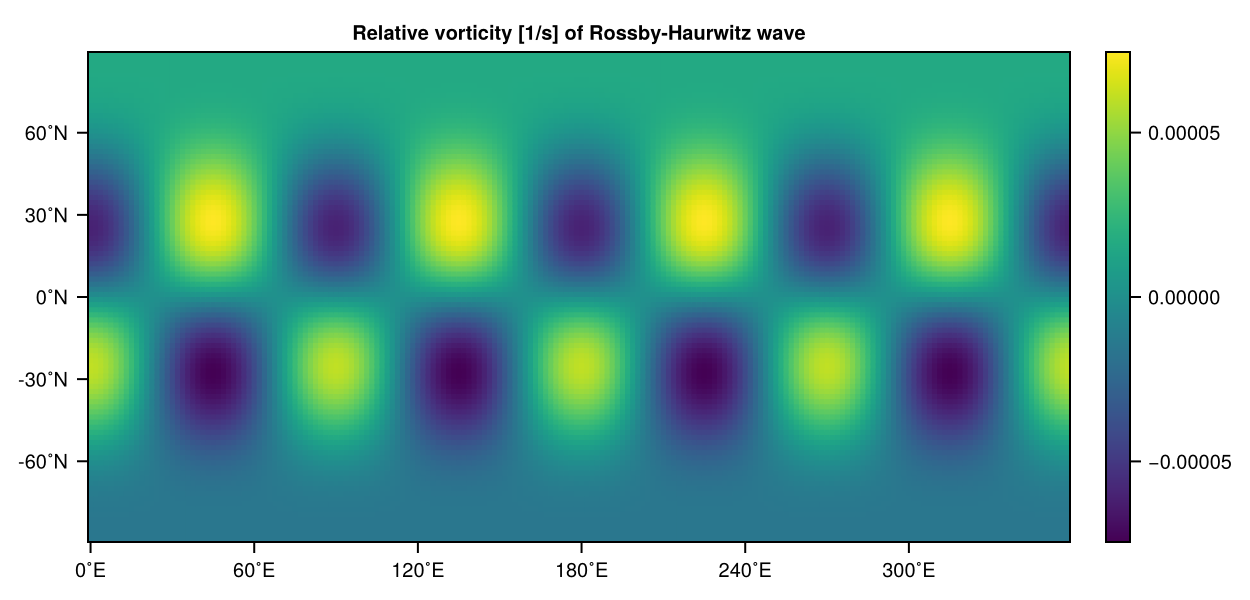

In [22]:
#Create a grid
spectral_grid = SpectralGrid(trunc=63, nlayers=5)

# Create model with default timestepper
model_m2 = PrimitiveWetModel(spectral_grid)

# 2️⃣ Method 2: Using set! function
simulation_m2 = initialize!(model_m2)

m = 4
ω = 7.848e-6
K = 7.848e-6

ζ(λ, θ, σ) = 2ω*sind(θ) - K*sind(θ)*cosd(θ)^m*(m^2 + 3m + 2)*cosd(m*λ)
set!(simulation_m2, vor=ζ)

# [1] for first leapfrog time step, [:, 1] for all values on first layer
vor = simulation_m2.prognostic_variables.vor[:, 1, 1]
vor_grid = transform(vor)

heatmap(vor_grid, title="Relative vorticity [1/s] of Rossby-Haurwitz wave")

In [17]:
run!(simulation_m2, period=Day(5))

Weather is speedy: 100%|██████████████████| Time: 0:00:06 (183.73 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

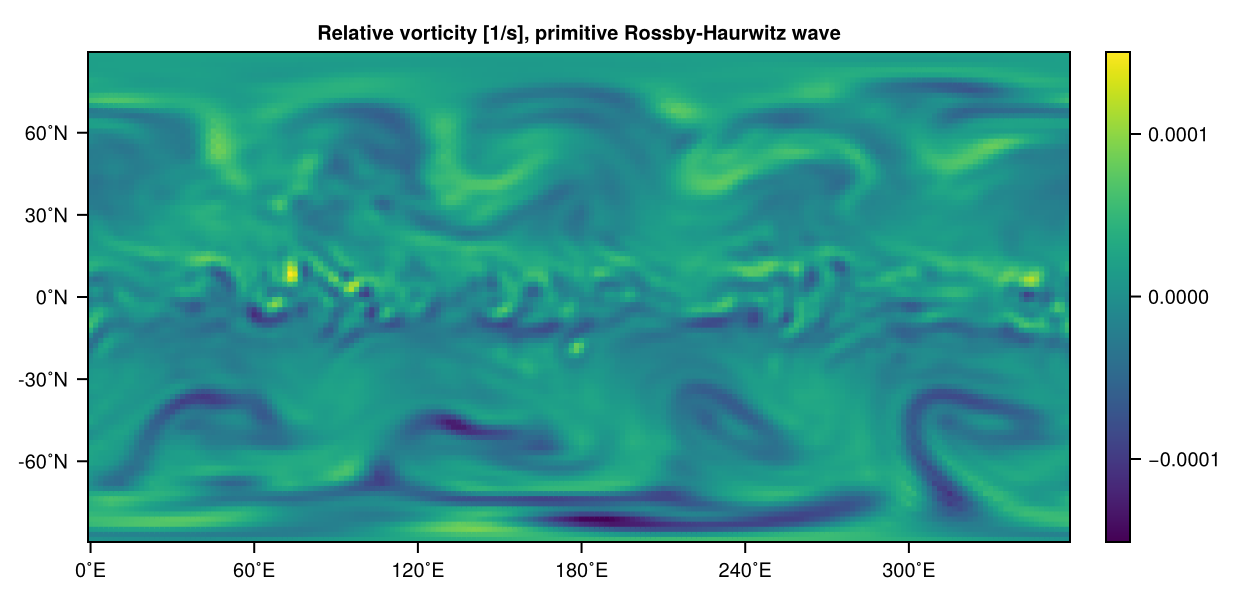

In [18]:
vor = simulation_m2.diagnostic_variables.grid.vor_grid[:, 3]
heatmap(vor, title="Relative vorticity [1/s], primitive Rossby-Haurwitz wave")

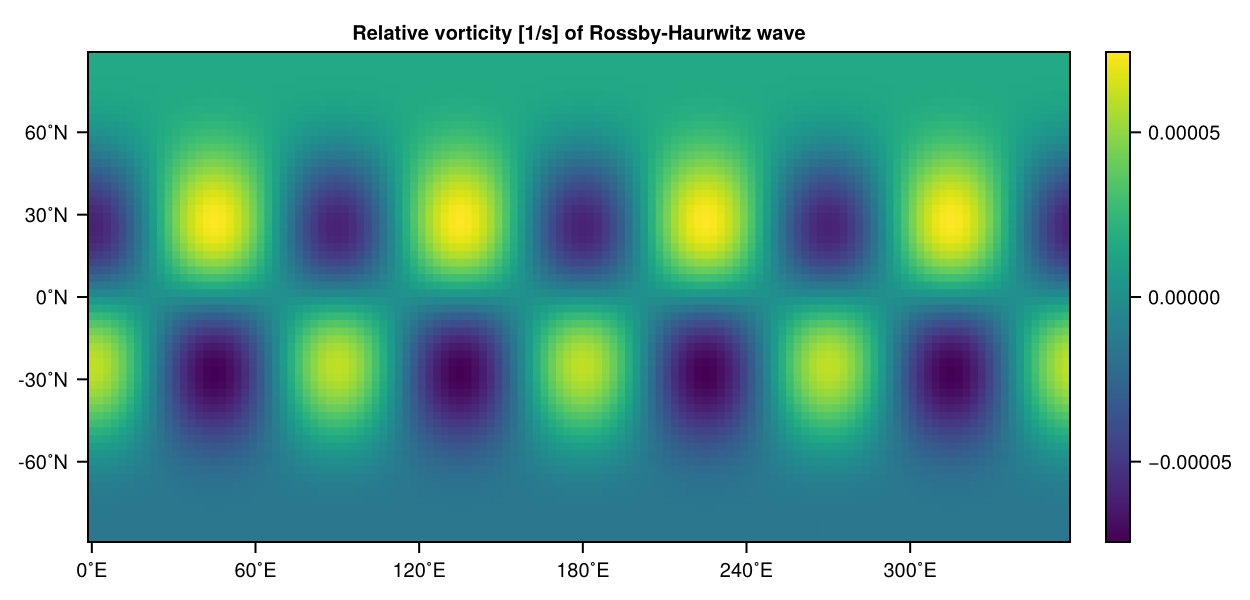

In [23]:
# 3️⃣ Method 3: Using a predefined initial condition struct
spectral_grid = SpectralGrid(trunc=42, nlayers=8)
initial_conditions = InitialConditions(
                        vordiv=RossbyHaurwitzWave(),
                        temp=JablonowskiTemperature(),
                        pres=PressureOnOrography())

orography = NoOrography(spectral_grid)
time_stepping = Leapfrog(spectral_grid, Δt_at_T31=Minute(30))   # 30min timestep scaled linearly

model_m3 = PrimitiveDryModel(spectral_grid; time_stepping, initial_conditions, orography, physics=false)
simulation_m3 = initialize!(model_m3)

vor = simulation_m3.prognostic_variables.vor[:, 1, 1]
vor_grid = transform(vor)

heatmap(vor_grid, title="Relative vorticity [1/s] of Rossby-Haurwitz wave")

In [24]:
run!(simulation_m3, period=Day(5))

Weather is speedy: 100%|██████████████████| Time: 0:00:01 (1017.16 years/day)


Simulation{PrimitiveDryModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveDryModel{...}

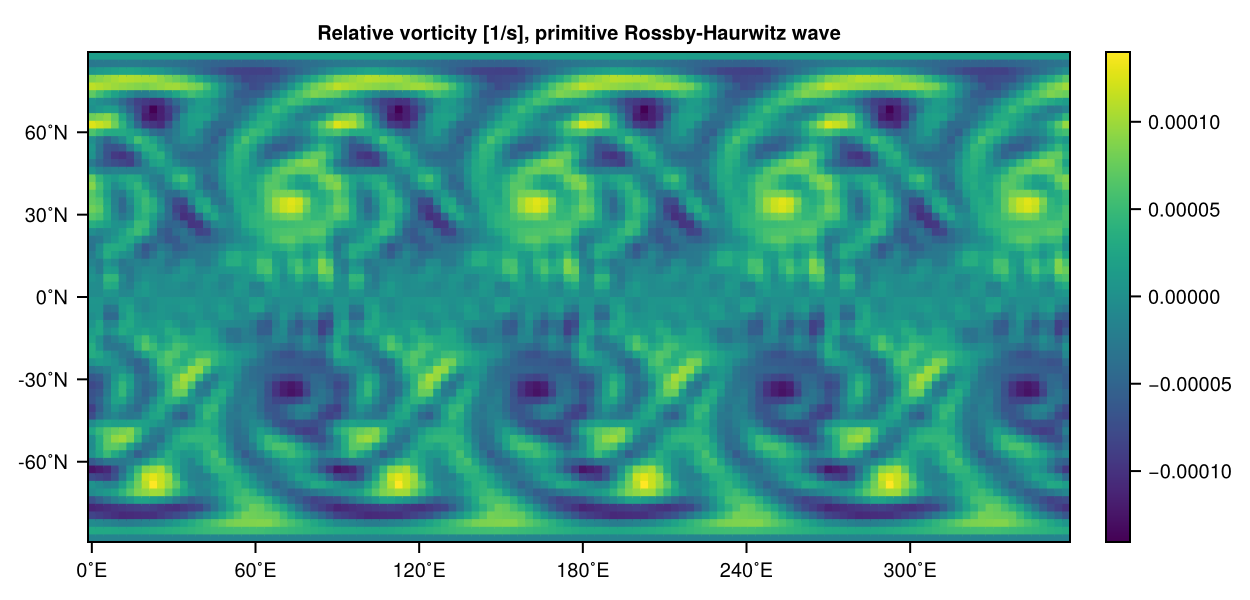

In [25]:
vor = simulation_m3.diagnostic_variables.grid.vor_grid[:, end] 
#`end` indexes the last item of the array, equivalent to -1 in Python.
# Because levels are stored from top to bottom, this returns the surface level.
heatmap(vor, title="Relative vorticity [1/s], primitive Rossby-Haurwitz wave")

#### 🧠 Exercise 1: 
Can you explain how and why the anomaly evolves?
What physical processes (advection, wave propagation, etc.) do you think dominate the evolution?

#### 💪 Exercise 2: 
Modify the initial conditions — for example, introduce a temperature anomaly in a specific region (e.g., a warm spot at the equator or a cold blob near the pole).
Then run the model and observe how this anomaly evolves over time.

👉 You might ask yourself:

- Does the anomaly move? If yes, in which direction?

- Does it spread out or stay compact?

- How does it interact with the wind field?

#### 💡 Hints: 
- Create a temperature perturbation as a function of coordinates, vertical level, amplitude and width of the anomaly.
- Introduce it to the model using _set!_ .
- This formulation can help you set!(simulation, temp=(λ, θ, σ) -> your_function, add=true). 

In [26]:
# Setup grid and model
spectral_grid = SpectralGrid(trunc=63, nlayers=5)
orography = NoOrography(spectral_grid)
time_stepping = Leapfrog(spectral_grid, Δt_at_T31=Minute(30))   # 30min timestep scaled linearly
model = PrimitiveWetModel(spectral_grid; orography, time_stepping)
simulation = initialize!(model)

λ₀ = 180.0
θ₀ = 0.0
σ₀ = 0.0
amp = 100.0
width = 20.0

# Update the simulation
set!(simulation, temp=(λ, θ, σ) -> amp * exp((-(λ - λ₀)^2 - (θ - θ₀)^2) / (2 * width^2)) * exp(-((σ - σ₀)^2) / (2 * 0.1^2)), add=true)

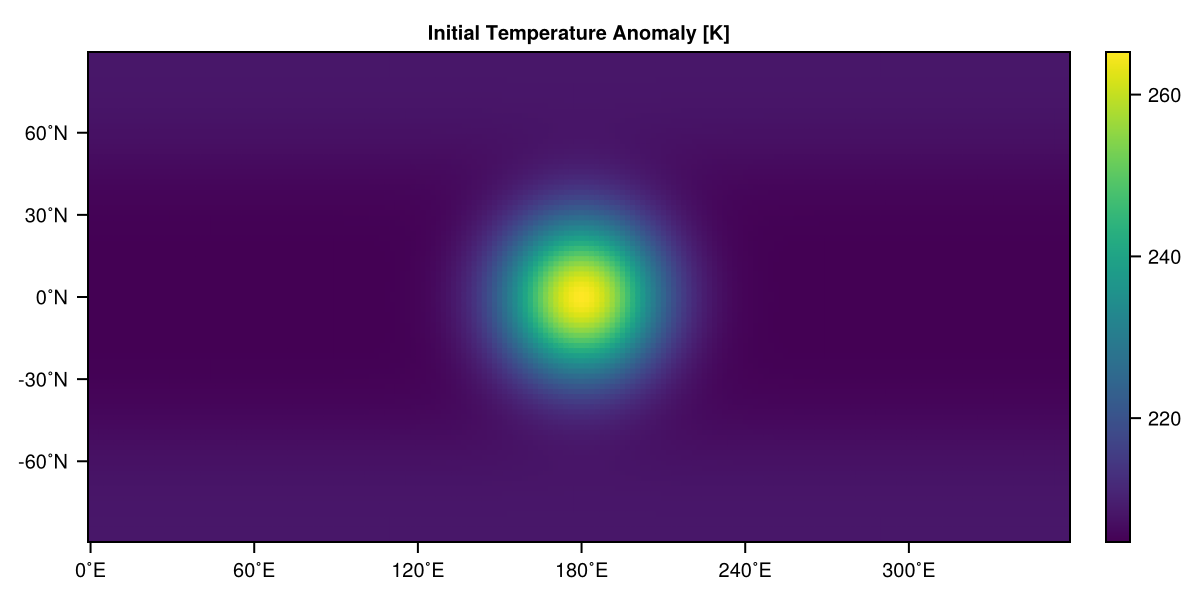

In [27]:
# Plot initial anomaly
T_0 = simulation.prognostic_variables.temp[:, 1, 1]
T_grid = transform(T_0)
heatmap(T_grid, title="Initial Temperature Anomaly [K]")

In [28]:
# Run the model
run!(simulation, period=Day(5))

Weather is speedy: 100%|██████████████████| Time: 0:00:08 (144.49 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

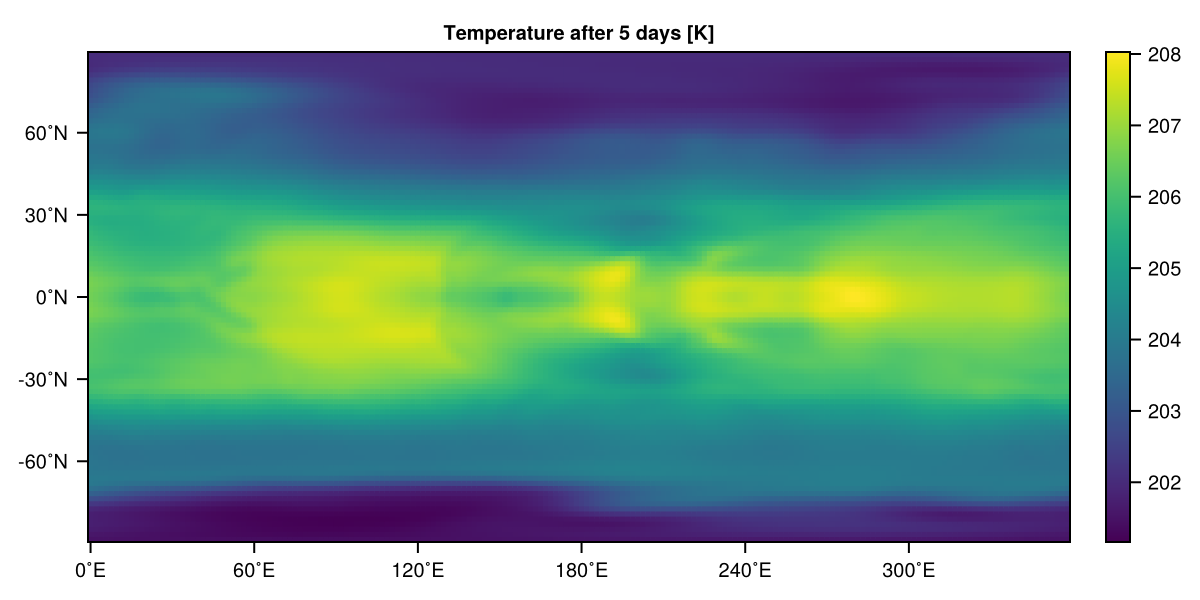

In [29]:
# Plot temperature at layer 1 after 5 days
T_end = simulation.diagnostic_variables.grid.temp_grid[:, 1]
heatmap(T_end, title="Temperature after 5 days [K]")